# Range error

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
### Import the data
error_data = pd.read_csv("range_error_data.csv")

In [3]:
ANGLE_LIMIT_DEG = 70

### 1. Data visualization

/tmp/ipykernel_316217/90152693.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(y_ticks)


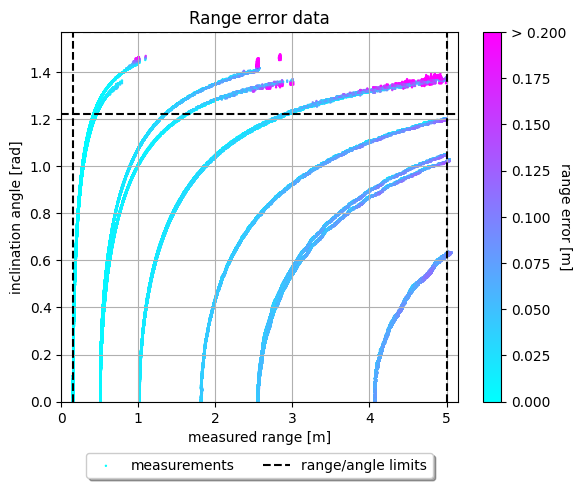

In [5]:
"""Plot distance vs. angle"""

plt.close("all")
fig, ax = plt.subplots(1, 1)
ranges, angles, errors = error_data["ranges"], error_data["angles"], error_data["errors"]
# ax.scatter(ranges, angles, c=np.clip(np.abs(errors), 0, 0.07), s=1)
# errors_clipped = np.clip(np.abs(errors), 0, errors[angles < np.radians(ANGLE_LIMIT_DEG)].max())
errors_clipped = np.clip(np.abs(errors), 0, 0.2)
# errors_clipped = np.abs(errors)
idcs_sorted = np.argsort(errors_clipped)
ax.scatter(ranges[idcs_sorted], angles[idcs_sorted], c=errors_clipped[idcs_sorted], s=0.5, cmap="cool", label="measurements")
# ax.scatter(ranges[idcs_sorted], angles[idcs_sorted], c=errors_clipped[idcs_sorted], s=1, cmap='viridis')

ax.set_xlim(0, 5.15)
ax.set_ylim(0.0, np.pi / 2)
ax.vlines(0.15, *ax.get_ylim(), color="k", linestyles="--", label="range/angle limits")
ax.vlines(5, *ax.get_ylim(), color="k", linestyles="--")
ax.hlines(np.pi / 2, *ax.get_xlim(), color="k", linestyles="--")
ax.hlines(np.radians(ANGLE_LIMIT_DEG), *ax.get_xlim(), color="k", linestyles="--")

ax.set_xlabel("measured range [m]")
ax.set_ylabel("inclination angle [rad]")
ax.set_title("Range error data")

ax.grid()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=True, ncol=5)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, errors_clipped.max()), cmap="cool"), ax=ax)
y_ticks = cbar.ax.get_yticklabels()
y_ticks[-1].set_text("> " + y_ticks[-1].get_text())
cbar.ax.set_yticklabels(y_ticks)
cbar.set_label("range error [m]", rotation=270)

# plt.savefig("range_error_data.pdf", bbox_inches="tight")
plt.savefig("range_error_data.png", dpi=600, bbox_inches="tight")

### 2. Model fit

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Ignore the GPU

### Import the `lib` directory
import pathlib
import sys

repo_directory = pathlib.Path().resolve().parents[1]
lib_module_dir = str(repo_directory.joinpath("lib"))
if lib_module_dir not in sys.path:
    sys.path.insert(0, str(repo_directory.joinpath("lib")))

from dual_gp_model_SVGP import DualGaussianProcessWrapper, make_train_test_split

2024-08-15 00:21:34.479775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 00:21:35.355976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
EPOCHS: int = 500  # 500
INDUCING_POINTS: int = 10
GRID_SIZE: int = 1000
LEARNING_RATE_FACTOR: float = 0.01
SCALE_FACTOR: float = 100

In [7]:
# remove data beyond the boundaries of:
#  - range: [0.15, 5] meters
#  - inclination angle: [0, 70] degrees
angle_mask = (error_data["angles"].to_numpy() >= 0) & (error_data["angles"].to_numpy() <= np.radians(70))
x_data = np.vstack([error_data["ranges"], error_data["angles"]]).T[angle_mask]
y_data = error_data["errors"].to_numpy()[angle_mask]


GP_model = DualGaussianProcessWrapper(
    x_data=x_data,
    y_data=y_data,
    train_mask=make_train_test_split(angle_mask.sum()),
    no_inducing_points=INDUCING_POINTS,
    data_directory=str(pathlib.Path().resolve()),  # current directory
    scale_factor=SCALE_FACTOR,
)

2024-08-15 00:21:40.177882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-15 00:21:40.177914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: christiaan-HP-ZBook-Studio-G5
2024-08-15 00:21:40.177922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: christiaan-HP-ZBook-Studio-G5
2024-08-15 00:21:40.178009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.90.7
2024-08-15 00:21:40.178035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.90.7
2024-08-15 00:21:40.178042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.90.7


Going to train for 500 epochs...


  0%|          | 0/500 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead


2024-08-15 00:21:45.064177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_grad/diag/diag_part/k' with dtype int32
	 [[{{node gradients/diag_part_grad/diag/diag_part/k}}]]
2024-08-15 00:21:45.105335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad/ReverseV2/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/MatrixBandPart/fill_triangular_CONSTRUCTED_AT_top_level/forward/fill_triangular/ReverseV2_grad

Epoch 1: 	 train_elbo = -270590.22 	 test_elbo = -67722.24
Epoch 2: 	 train_elbo = -265822.29 	 test_elbo = -66532.46
Epoch 3: 	 train_elbo = -259201.52 	 test_elbo = -64883.39
Epoch 4: 	 train_elbo = -249988.69 	 test_elbo = -62592.91
Epoch 5: 	 train_elbo = -238486.01 	 test_elbo = -59739.89
Epoch 6: 	 train_elbo = -226657.97 	 test_elbo = -56818.29
Epoch 7: 	 train_elbo = -216764.97 	 test_elbo = -54389.47
Epoch 8: 	 train_elbo = -208648.67 	 test_elbo = -52400.63
Epoch 9: 	 train_elbo = -201053.07 	 test_elbo = -50530.38
Epoch 10: 	 train_elbo = -193433.27 	 test_elbo = -48643.35
Epoch 11: 	 train_elbo = -185721.48 	 test_elbo = -46725.41
Epoch 12: 	 train_elbo = -178002.10 	 test_elbo = -44800.50
Epoch 13: 	 train_elbo = -170416.72 	 test_elbo = -42906.04
Epoch 14: 	 train_elbo = -163129.18 	 test_elbo = -41084.61
Epoch 15: 	 train_elbo = -156284.73 	 test_elbo = -39373.99
Epoch 16: 	 train_elbo = -149955.59 	 test_elbo = -37793.56
Epoch 17: 	 train_elbo = -144107.10 	 test_elbo =

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 500: 	 train_elbo = -29438.26 	 test_elbo = -8358.64
Plotting the posterior...


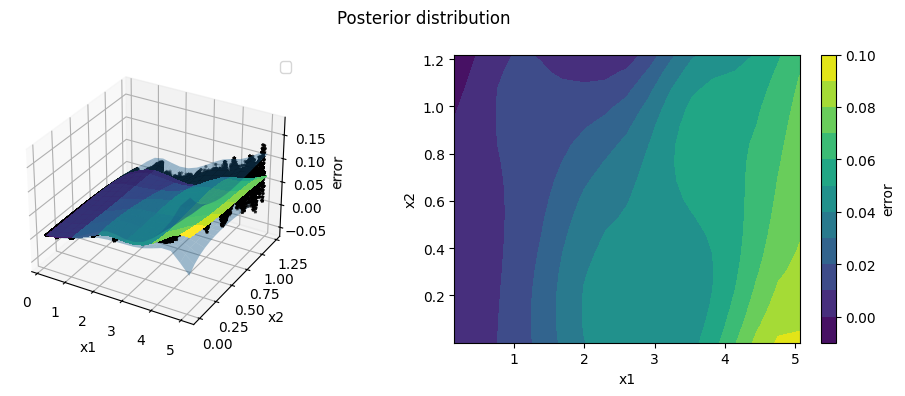

Generating the error model (interpolation grid)...


2024-08-15 02:56:08.336441: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6400000000 exceeds 10% of free system memory.
2024-08-15 02:56:09.485048: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6400000000 exceeds 10% of free system memory.
2024-08-15 02:56:11.079175: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.
2024-08-15 02:56:11.751762: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.
2024-08-15 02:56:12.410089: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.


Saving the error model...
Done


In [8]:
print(f"Going to train for {EPOCHS} epochs...")
GP_model.train(epochs=EPOCHS, lr_factor=LEARNING_RATE_FACTOR)
print(f"Plotting the posterior...")
GP_model.plot_posterior()
print(f"Generating the error model (interpolation grid)...")
GP_model.generate_error_model(
    grid_size=GRID_SIZE, model_info={"error": "Lidar range error", "param1": "range", "param2": "angle"}
)
print(f"Saving the error model...")
GP_model.save_error_model()
print("Done")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_9648/3755663289.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cm = mpl.cm.get_cmap("viridis")


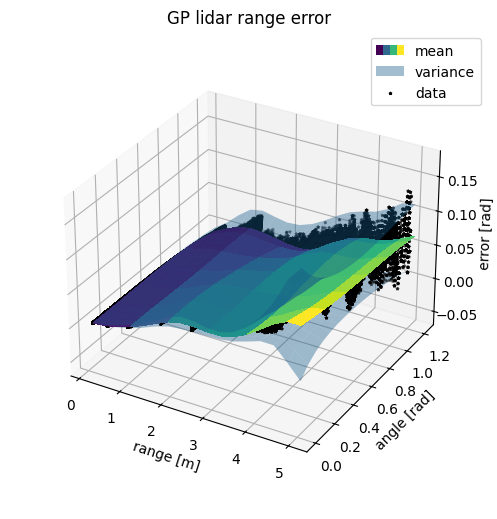

In [9]:
### Save the GP picture
from matplotlib.legend_handler import HandlerTuple

fig = GP_model.plot_posterior(return_fig=True)
ax1, ax2, cbar = fig.get_axes()
ax2.remove()
cbar.remove()
ax1.set_xlabel("range [m]")
ax1.set_ylabel("angle [rad]")
ax1.set_zlabel("error [rad]")

fig.suptitle("")
ax1.set_title("GP lidar range error")

ax1.set_box_aspect(aspect=None, zoom=0.88)

# ax1.legend([ax1.get_children()[1], ax1.get_children()[2]], ["mean", "variance"])

steps = 4
viridis_cm = mpl.cm.get_cmap("viridis")
colourmap_handle = []
for i in range(steps):
    colourmap_handle.append(mpl.patches.Patch(facecolor=viridis_cm(i / (steps - 1))))

ax1.legend(
    [colourmap_handle, ax1.get_children()[2], ax1.get_children()[0]],
    ["mean", "variance", "data"],
    handler_map={list: HandlerTuple(None, pad=0)},
)

fig.set_size_inches(10, 10)
fig.tight_layout()
fig.savefig("range_error_gp.pdf", bbox_inches="tight")
fig.savefig("range_error_gp.png", dpi=300, bbox_inches="tight")

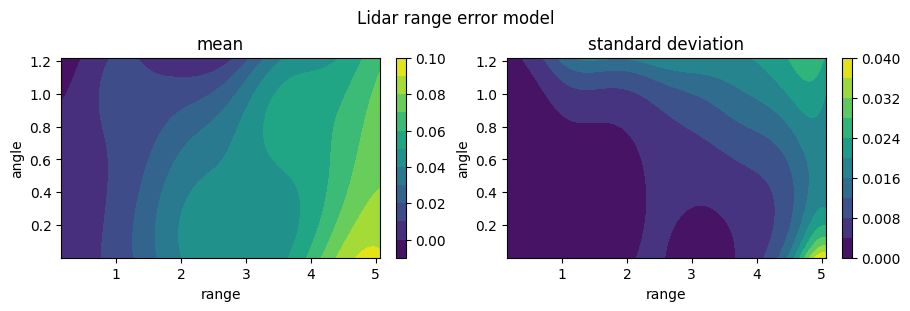

In [10]:
GP_model.error_model.plot()